# IRMAS Test Evaluation

Load the trained `CNNVarTime` checkpoint, run it on the precomputed IRMAS test mel windows, aggregate predictions back to the clip level, and report clip-level accuracy.


In [ ]:
IRMAS_TEST_MANIFEST = "data/manifests/irmas_test_mels.csv"
RESUME_CKPT = "saved_weights/irmas_pretrain_single_class/train_2/best_epoch_0075_val_acc_66.50.pt"
BATCH_SIZE = 32
DEVICE = "cpu" 
NUM_WORKERS = 4

PROJECT_ROOT = Path.cwd()

In [35]:
train_order_names, label_to_idx = class_names_from_ckpt(RESUME_CKPT, IRMAS_CLASSES)
num_classes = len(train_order_names)
print("Class order from ckpt:", train_order_names)

# ----------------- MODEL -----------------
model = CNNVarTime(in_ch=2, num_classes=num_classes, p_drop=0.5).to(DEVICE)
state_dict = load_model_state(RESUME_CKPT)
missing, unexpected = model.load_state_dict(state_dict, strict=True)
assert not missing and not unexpected, f"state_dict mismatch: missing={missing} unexpected={unexpected}"
model.eval()
PIN_MEM = DEVICE.startswith("cuda")

# ----------------- DATASET / LOADER -----------------
# IMPORTANT: pass class_names=train_order_names so targets align with the checkpoint order
test_ds = IRMASTestWindowDataset(
    manifest_csv=Path(IRMAS_TEST_MANIFEST),
    project_root=PROJECT_ROOT,
    class_names=train_order_names,
    per_example_norm=True,   # keep consistent with training
)

# quick sanity checks
assert len(test_ds) > 0, "Empty test dataset."
x0, y0, clip0, p0 = test_ds[0]
assert x0.ndim == 3 and x0.shape[0] == 2, f"Expected mel shape (2, 128, T); got {tuple(x0.shape)}"
assert y0.numel() == num_classes, f"Target length {y0.numel()} != num_classes {num_classes}"

test_loader = DataLoader(
    test_ds, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS, pin_memory=PIN_MEM
)
print("Test windows:", len(test_ds))

# ----------------- EVAL (clip-level by averaging logits) -----------------
logits_by_clip = defaultdict(list)
labels_by_clip = {}
windows_per_clip = defaultdict(int)

with torch.no_grad():
    for inputs, targets, clip_ids, paths in test_loader:
        inputs = inputs.to(DEVICE, non_blocking=PIN_MEM)
        logits = model(inputs)                     # (B, C) raw logits (pre-softmax)
        logits_cpu = logits.detach().cpu().numpy()
        targets_np = targets.cpu().numpy()

        for logit_vec, target_vec, clip_id in zip(logits_cpu, targets_np, clip_ids):
            logits_by_clip[clip_id].append(logit_vec)               # accumulate windows
            labels_by_clip[clip_id] = target_vec.astype(np.float32) # multi-hot GT per clip
            windows_per_clip[clip_id] += 1

rows = []
for clip_id, logit_list in logits_by_clip.items():
    stacked = np.stack(logit_list, 0)       # (W, C)
    mean_logits = stacked.mean(axis=0)      # (C,)

    # Single-class head (CE): convert to softmax probs for readability
    exp = np.exp(mean_logits - mean_logits.max())
    probs = exp / exp.sum()

    pred_idx = int(mean_logits.argmax())
    gt_vec = labels_by_clip[clip_id]        # multi-hot from manifest
    hit1 = bool(gt_vec[pred_idx] > 0.5)

    order = np.argsort(mean_logits)[::-1]
    top3 = ", ".join(f"{train_order_names[i]} ({probs[i]:.2f})" for i in order[:3])
    true_names = [train_order_names[i] for i, v in enumerate(gt_vec) if v > 0.5]

    rows.append({
        "clip": clip_id,
        "true_labels": "|".join(true_names),
        "pred_label": train_order_names[pred_idx],
        "pred_score": float(probs[pred_idx]),
        "top3": top3,
        "hit@1": hit1,
        "windows": int(windows_per_clip[clip_id]),
    })

df = pd.DataFrame(rows).sort_values(["hit@1", "pred_score"], ascending=[True, False])
print("Clip-level Top-1 accuracy:", df["hit@1"].mean())
try:
    display(df.head(10))
except NameError:
    print(df.head(10).to_string(index=False))

Class order from ckpt: ['cel', 'cla', 'flu', 'gac', 'gel', 'org', 'pia', 'sax', 'tru', 'vio', 'voi']
Test windows: 4958
Clip-level Top-1 accuracy: 0.06319702602230483


,clip,true_labels,pred_label,pred_score,top3,hit@1,windows
420,01 Organ Grinder's Swing-7.wav,cel,voi,0.999604,"voi (1.00), flu (0.00), gel (0.00)",False,2
422,01 Start Making Noise-1.wav,cel,gac,0.997615,"gac (1.00), pia (0.00), gel (0.00)",False,4
120,01 - Inolvidable-12.wav,cel,voi,0.996545,"voi (1.00), vio (0.00), sax (0.00)",False,2
430,01 Start Making Noise-6.wav,cel|sax,voi,0.996373,"voi (1.00), flu (0.00), sax (0.00)",False,7
128,01 - Inolvidable-9.wav,cel|gel,voi,0.995927,"voi (1.00), flu (0.00), vio (0.00)",False,2
12,00 - gold fronts-1.wav,cel,voi,0.995455,"voi (1.00), flu (0.00), sax (0.00)",False,4
122,01 - Inolvidable-2.wav,cel|gel,voi,0.995092,"voi (1.00), flu (0.00), vio (0.00)",False,2
53,01 - Canto das três raças-2.wav,cel|sax,voi,0.994766,"voi (0.99), sax (0.00), gel (0.00)",False,7
124,01 - Inolvidable-4.wav,cel|gel,voi,0.993829,"voi (0.99), flu (0.00), sax (0.00)",False,5
431,01 Start Making Noise-7.wav,cel|sax,voi,0.990965,"voi (0.99), flu (0.00), sax (0.00)",False,7


# Evaluation on IRMAS test 



In [36]:
per_class = []
for ci, cname in enumerate(train_order_names):
    mask = df["true_labels"].str.contains(rf"(?:^|[|]){cname}(?:$|[|])")
    support = int(mask.sum())
    correct = int((df.loc[mask, "pred_label"] == cname).sum())
    per_class.append({"class": cname, "support": support, "hit_rate": (correct / support if support else float("nan"))})
per_class_df = pd.DataFrame(per_class).sort_values("hit_rate", ascending=False)
per_class_df


,class,support,hit_rate
10,voi,23,0.869565
5,org,29,0.137931
9,vio,22,0.136364
4,gel,64,0.093750
3,gac,32,0.031250
1,cla,218,0.022936
0,cel,807,0.014870
2,flu,112,0.000000
6,pia,98,0.000000
7,sax,27,0.000000


# Appendix


Total windows: 4958
Unique clips: 807

Label distribution:
  cel               178 ( 2.0%)
  cla                43 ( 0.5%)
  flu               191 ( 2.1%)
  gac               958 (10.7%)
  gel              1476 (16.5%)
  org               559 ( 6.3%)
  pia              2285 (25.6%)
  sax              1099 (12.3%)
  tru               496 ( 5.6%)
  vio               350 ( 3.9%)
  voi              1289 (14.4%)

Per-clip summary (first few):
                    irmas_filename  windows       labels
0   (02) dont kill the whale-1.wav        7  00001000000
1  (02) dont kill the whale-11.wav        4  00001000000
2  (02) dont kill the whale-12.wav        3  00001000001
3  (02) dont kill the whale-13.wav        3  00001000001
4  (02) dont kill the whale-14.wav        5  00001000001


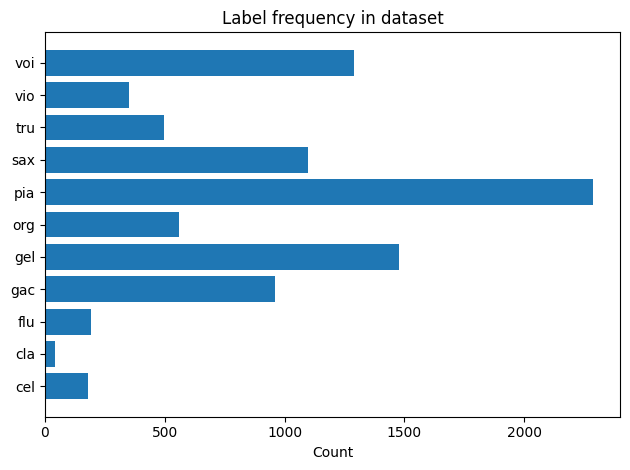

In [ ]:
C = len(IRMAS_CLASSES)
df = pd.read_csv(IRMAS_TEST_MANIFEST, dtype={"label_multi": str})

# Ensure string, strip whitespace, and pad/trim to expected length C
def norm_multihot(x: str) -> str:
    if x is None or (isinstance(x, float) and np.isnan(x)):
        return "0" * C
    s = str(x).strip()
    # If someone wrote e.g. 101 as int, dtype above already made it '101'
    # Pad left with zeros if too short; trim if too long
    if len(s) < C:
        s = s.zfill(C)
    elif len(s) > C:
        s = s[:C]
    # validate characters
    if any(ch not in "01" for ch in s):
        raise ValueError(f"Non-binary label_multi: {s!r}")
    return s

df["label_multi"] = df["label_multi"].apply(norm_multihot)

# Active class indices per row
df["active_classes"] = df["label_multi"].apply(
    lambda s: [i for i, ch in enumerate(s) if ch == "1"]
)

# --- sanity checks (optional but handy) ---
# Check for unexpected lengths/values
bad_len = df["label_multi"].map(len).ne(C).sum()
if bad_len:
    raise RuntimeError(f"{bad_len} rows have wrong label length (expected {C}).")

# --- summary ---
total_windows = len(df)
unique_clips = df["irmas_filename"].nunique() if "irmas_filename" in df.columns else df["filepath"].nunique()

print(f"Total windows: {total_windows}")
print(f"Unique clips: {unique_clips}")

# Per-class counts across windows
label_counts = Counter(i for row in df["active_classes"] for i in row)
total_labels = sum(label_counts.values()) or 1

print("\nLabel distribution:")
for i in range(C):
    count = label_counts.get(i, 0)
    pct = 100 * count / total_labels
    print(f"  {IRMAS_CLASSES[i]:15s} {count:5d} ({pct:4.1f}%)")

# Per-clip summary table
group_key = "irmas_filename" if "irmas_filename" in df.columns else "filepath"
summary = (
    df.groupby(group_key, as_index=False)
      .agg(
          windows=("filepath", "count"),
          labels=("label_multi", "first"),
      )
)
print("\nPer-clip summary (first few):")
print(summary.head())

# Optional: bar plot of label frequencies (requires matplotlib)
import matplotlib.pyplot as plt
plt.barh(
    [IRMAS_CLASSES[i] for i in range(C)],
    [label_counts.get(i, 0) for i in range(C)],
)
plt.xlabel("Count")
plt.title("Label frequency in dataset")
plt.tight_layout()
plt.show()